# Purpose

This notebook is to do analysis on the distribution of listening events across AllMusic artist genres
## Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import os

## Preparing Data

In [2]:
listeningEvents = pd.read_parquet('../data/LastFM1bKidListeningEventsWithUsers', columns = ['Education Level', 'Age', 'Artist', 'User Id'])
listeningEvents.drop(columns = ['Partition'], inplace = True)
listeningEvents.head(5)

,Education Level,Age,Artist,User Id
0,HS,16,I BREAK HORSES,15397460
1,HS,16,TAYLOR SWIFT,15397460
2,HS,16,HIM,15397460
3,HS,16,AMARANTHE,15397460
4,HS,16,AMARANTHE,15397460


In [3]:
artistToGenre = pd.read_parquet('../data/LastFM1bKidArtistToAllMusicGenre.gzip.parquet')
artistToGenre.head(5)

,Artist,Genre
0,MEGADETH,HEAVY METAL
1,DREAM THEATER,HEAVY METAL
2,AMON AMARTH,HEAVY METAL
3,ALTER BRIDGE,HEAVY METAL
4,LIMP BIZKIT,HEAVY METAL


In [4]:
data = listeningEvents.merge(artistToGenre, on = 'Artist')
data.drop(columns = ['Artist'], inplace = True)
data.head(5)

,Education Level,Age,User Id,Genre
0,HS,16,15397460,ROCK
1,HS,16,15397460,POP
2,HS,16,15397460,ALTERNATIVE
3,HS,16,15397460,ELECTRONIC
4,GS,10,2014225,ROCK


In [5]:
listeningEvents = artistToGenre = None

## Computing Mean Genre Listening Event per User 

In [6]:
data = data.groupby(['Education Level', 'Age', 'User Id', 'Genre'], observed = True).agg(Count = ('Genre', 'count')).reset_index()
data.head(5)

,Education Level,Age,User Id,Genre,Count
0,HS,15,7576766,ROCK,12762
1,HS,15,7576766,POP,11980
2,HS,15,7576766,ALTERNATIVE,17276
3,HS,15,7576766,ELECTRONIC,11630
4,HS,15,7576766,FOLK,5057


In [7]:
temp = data.groupby(['User Id']).agg(Total = ('Count', 'sum')).reset_index()
temp.head(5)

,User Id,Total
0,2014225,70768
1,2484832,82317
2,2635077,471954
3,2921901,64092
4,3556768,44236


In [8]:
data = data.merge(temp, on = 'User Id')
data.head(5)

,Education Level,Age,User Id,Genre,Count,Total
0,HS,15,7576766,ROCK,12762,70449
1,HS,15,7576766,POP,11980,70449
2,HS,15,7576766,ALTERNATIVE,17276,70449
3,HS,15,7576766,ELECTRONIC,11630,70449
4,HS,15,7576766,FOLK,5057,70449


In [9]:
data['Mean'] = data['Count'] / data['Total']
data.head(5)

,Education Level,Age,User Id,Genre,Count,Total,Mean
0,HS,15,7576766,ROCK,12762,70449,0.181152
1,HS,15,7576766,POP,11980,70449,0.170052
2,HS,15,7576766,ALTERNATIVE,17276,70449,0.245227
3,HS,15,7576766,ELECTRONIC,11630,70449,0.165084
4,HS,15,7576766,FOLK,5057,70449,0.071782


## Computing Mean Genre Listening Event per User per Education Level

In [10]:
graphData = data.groupby(['Education Level', 'Genre'], observed = True).agg(Mean = ('Mean', 'mean'))
graphData = graphData.reset_index()
graphData.head(5)

,Education Level,Genre,Mean
0,HS,ROCK,0.205203
1,HS,POP,0.133651
2,HS,ALTERNATIVE,0.194183
3,HS,ELECTRONIC,0.107326
4,HS,FOLK,0.047714


### Raw Data

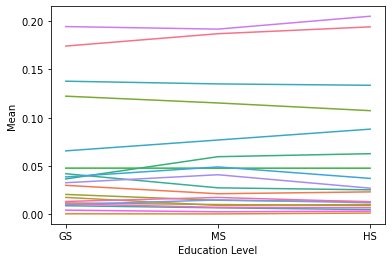

In [11]:
sns.lineplot(data = graphData, x = 'Education Level', hue = 'Genre', y = 'Mean', legend = False);

In [12]:
total = graphData.groupby('Genre').agg(Total = ('Mean', 'sum')).reset_index()

results = []
for pair in [('Top 1%', .01), ('Top 2%', .02), ('Top 3%', .03), ('Top 4%', .04), ('Top 5%', .05), ('Top 10%', .10), ('Top 50%', .50), ('All', 1)]:
    cutoff = np.quantile(total['Total'], q = 1 - pair[1])

    top = total[total['Total'] >= cutoff]['Genre']
    
    temp = graphData[graphData['Genre'].isin(top)].groupby(['Education Level']).agg(Top = ('Mean', 'sum')).rename(columns = {'Top': pair[0]})
    results.append(temp)
    
topData = pd.concat(results, axis = 1).unstack().reset_index().rename(columns = {'level_0': 'Quantile', 0: 'Value'})
topData

topData = topData.merge(topData[topData['Quantile'] == 'All'][['Education Level', 'Value']], on = 'Education Level')
topData['Value'] = topData['Value_x'] / topData['Value_y']
topData

,Quantile,Education Level,Value_x,Value_y,Value
0,Top 1%,GS,0.194490,1.018939,0.190876
1,Top 2%,GS,0.194490,1.018939,0.190876
2,Top 3%,GS,0.194490,1.018939,0.190876
3,Top 4%,GS,0.194490,1.018939,0.190876
4,Top 5%,GS,0.194490,1.018939,0.190876
5,Top 10%,GS,0.368791,1.018939,0.361937
6,Top 50%,GS,0.892176,1.018939,0.875593
7,All,GS,1.018939,1.018939,1.000000
8,Top 1%,MS,0.191848,1.034096,0.185523
9,Top 2%,MS,0.191848,1.034096,0.185523


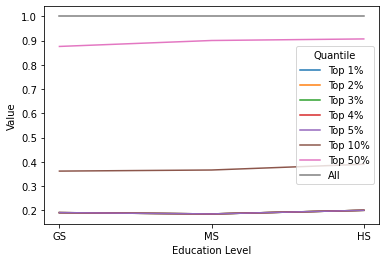

In [13]:
sns.lineplot(data = topData, x = 'Education Level', hue = 'Quantile', y = 'Value');

In [14]:
total = graphData.groupby('Genre').agg(Total = ('Mean', 'sum')).reset_index()

results = []
for top in range(1, 101, 1):
    cutoff = np.quantile(total['Total'], q = 1 - (top / 100))

    topGenres = total[total['Total'] >= cutoff]['Genre']
    
    temp = graphData[graphData['Genre'].isin(topGenres)].groupby(['Education Level']).agg(Top = ('Mean', 'sum')).rename(columns = {'Top': top})
    results.append(temp)
    
topData = pd.concat(results, axis = 1).unstack().reset_index().rename(columns = {'level_0': 'Quantile', 0: 'Value'})
topData

topData = topData.merge(topData[topData['Quantile'] == 100][['Education Level', 'Value']], on = 'Education Level')
topData['Value'] = topData['Value_x'] / topData['Value_y']
topData

,Quantile,Education Level,Value_x,Value_y,Value
0,1,GS,0.194490,1.018939,0.190876
1,2,GS,0.194490,1.018939,0.190876
2,3,GS,0.194490,1.018939,0.190876
3,4,GS,0.194490,1.018939,0.190876
4,5,GS,0.194490,1.018939,0.190876
...,...,...,...,...,...
295,96,HS,1.022837,1.024020,0.998845
296,97,HS,1.022837,1.024020,0.998845
297,98,HS,1.022837,1.024020,0.998845
298,99,HS,1.022837,1.024020,0.998845


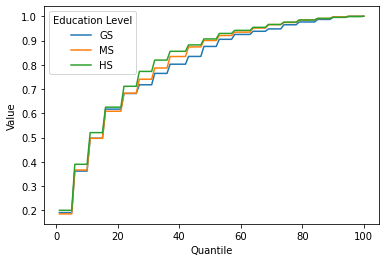

In [15]:
sns.lineplot(data = topData, x = 'Quantile', hue = 'Education Level', y = 'Value');

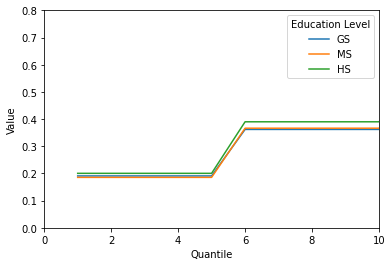

In [16]:
g = sns.lineplot(data = topData, x = 'Quantile', hue = 'Education Level', y = 'Value')
g.set(xlim = (0, 10), ylim = (0, .8));

## Computing Mean Genre Listening Event per User per High School Age

In [17]:
graphData = data.groupby(['Age', 'Genre'], observed = True).agg(Mean = ('Mean', 'mean'))
graphData = graphData.reset_index()
graphData.head(5)

,Age,Genre,Mean
0,6,ROCK,0.192020
1,6,POP,0.133180
2,6,ALTERNATIVE,0.175163
3,6,ELECTRONIC,0.093248
4,6,FOLK,0.044171


### Raw Data

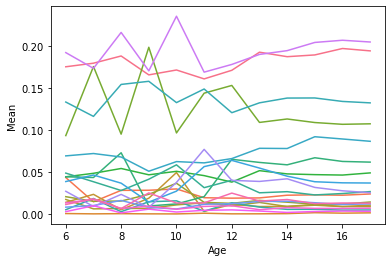

In [18]:
sns.lineplot(data = graphData, x = 'Age', hue = 'Genre', y = 'Mean', legend = False);

### Top % Quantile Genres

In [19]:
total = graphData.groupby('Genre').agg(Total = ('Mean', 'sum')).reset_index()

results = []
for pair in [('Top 1%', .01), ('Top 2%', .02), ('Top 3%', .03), ('Top 4%', .04), ('Top 5%', .05), ('Top 10%', .10), ('Top 50%', .50), ('All', 1)]:
    cutoff = np.quantile(total['Total'], q = 1 - pair[1])

    top = total[total['Total'] >= cutoff]['Genre']
    
    temp = graphData[graphData['Genre'].isin(top)].groupby(['Age']).agg(Top = ('Mean', 'sum')).rename(columns = {'Top': pair[0]})
    results.append(temp)
    
topData = pd.concat(results, axis = 1).unstack().reset_index().rename(columns = {'level_0': 'Quantile', 0: 'Value'})
topData

topData = topData.merge(topData[topData['Quantile'] == 'All'][['Age', 'Value']], on = 'Age')
topData['Value'] = topData['Value_x'] / topData['Value_y']
topData

,Quantile,Age,Value_x,Value_y,Value
0,Top 1%,6,0.192020,1.000582,0.191908
1,Top 2%,6,0.192020,1.000582,0.191908
2,Top 3%,6,0.192020,1.000582,0.191908
3,Top 4%,6,0.192020,1.000582,0.191908
4,Top 5%,6,0.192020,1.000582,0.191908
...,...,...,...,...,...
91,Top 4%,17,0.204645,1.021506,0.200336
92,Top 5%,17,0.204645,1.021506,0.200336
93,Top 10%,17,0.398729,1.021506,0.390335
94,Top 50%,17,0.923805,1.021506,0.904355


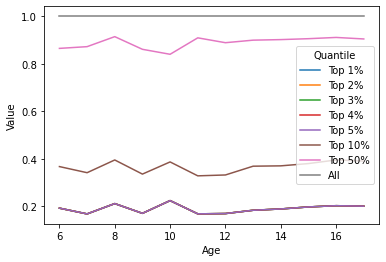

In [20]:
sns.lineplot(data = topData, x = 'Age', hue = 'Quantile', y = 'Value');

In [21]:
total = graphData.groupby('Genre').agg(Total = ('Mean', 'sum')).reset_index()

results = []
for top in range(1, 101, 1):
    cutoff = np.quantile(total['Total'], q = 1 - (top / 100))

    topGenres = total[total['Total'] >= cutoff]['Genre']
    
    temp = graphData[graphData['Genre'].isin(topGenres)].groupby(['Age']).agg(Top = ('Mean', 'sum')).rename(columns = {'Top': top})
    results.append(temp)
    
topData = pd.concat(results, axis = 1).unstack().reset_index().rename(columns = {'level_0': 'Quantile', 0: 'Value'})
topData

topData = topData.merge(topData[topData['Quantile'] == 100][['Age', 'Value']], on = 'Age')
topData['Value'] = topData['Value_x'] / topData['Value_y']
topData

,Quantile,Age,Value_x,Value_y,Value
0,1,6,0.192020,1.000582,0.191908
1,2,6,0.192020,1.000582,0.191908
2,3,6,0.192020,1.000582,0.191908
3,4,6,0.192020,1.000582,0.191908
4,5,6,0.192020,1.000582,0.191908
...,...,...,...,...,...
1195,96,17,1.020230,1.021506,0.998751
1196,97,17,1.020230,1.021506,0.998751
1197,98,17,1.020230,1.021506,0.998751
1198,99,17,1.020230,1.021506,0.998751


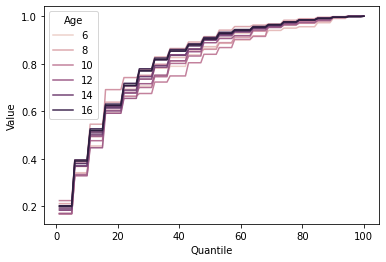

In [22]:
sns.lineplot(data = topData, x = 'Quantile', hue = 'Age', y = 'Value');

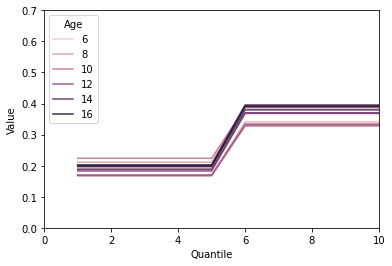

In [23]:
g = sns.lineplot(data = topData, x = 'Quantile', hue = 'Age', y = 'Value')
g.set(xlim = (0, 10), ylim = (0, .7));